<center>
<img src="https://supportvectors.ai/logo-poster-transparent.png" width="400px" style="opacity:0.7">
</center>

In [1]:
%run supportvectors-common.ipynb


<div style="color:#aaa;font-size:8pt">
<hr/>
&copy; SupportVectors. All rights reserved. <blockquote>This notebook is the intellectual property of SupportVectors, and part of its training material. 
Only the participants in SupportVectors workshops are allowed to study the notebooks for educational purposes currently, but is prohibited from copying or using it for any other purposes without written permission.

<b> These notebooks are chapters and sections from Asif Qamar's textbook that he is writing on Data Science. So we request you to not circulate the material to others.</b>
 </blockquote>
 <hr/>
</div>



# Text Embeddings for Clustering and Classification  

## Introduction  

Text embeddings are a powerful way to represent textual data in a numerical format, preserving semantic relationships between words, phrases, and documents. In this notebook, we will demonstrate how embeddings facilitate text classification and clustering by transforming unstructured text into structured vector representations.  

## Objectives  

1. **Load Preprocessed Text Chunks** – Retrieve previously chunked text documents.  
2. **Generate Text Embeddings** – Convert text into high-dimensional numerical representations using a sentence embedding model.  
3. **Reduce Dimensionality** – Apply dimensionality reduction techniques to visualize embeddings in a lower-dimensional space.  
4. **Cluster and Analyze** – Use clustering techniques to group similar text chunks based on their embeddings.  


By the end of this notebook, we will gain insights into how embeddings help uncover patterns in text data and improve classification and clustering tasks.  

#### ***Imports***

In [2]:
# Data Loading & Management

# HuggingFace Datasets: easy loading/manipulation of NLP corpora (via load_dataset, Dataset.from_dict, etc.)
# Example: fetch a text dataset from local files or HF Hub. 
# Alternative: pandas (read_csv) or torchtext for raw data.
from datasets import load_dataset, Dataset  

# Python’s OS module: for filesystem and environment operations
# Alternative: Python’s pathlib for path handling.
import os


In [3]:
# Machine Learning & Embedding Libraries

# PyTorch: tensor library for deep learning. 
# Provides Tensors (like NumPy arrays) with GPU acceleration and Automatic Differentiation (Autograd).
# Required by SentenceTransformers (which uses PyTorch under the hood). 
# Alternative frameworks: TensorFlow or JAX.
import torch                          

# Python typing: for type annotations (e.g., Dict[str,Any], List[int])
# Improves code clarity/IDE support but not enforced at runtime. 
# In Python 3.9+, built-in generics (dict[str,int], list[str]) are preferred
# Alternatives: omit type hints or use `typing_extensions`.
from typing import Dict, List, Any       

# SentenceTransformers (SBERT): loads pretrained transformer models to compute sentence/document embeddings.
# Use `SentenceTransformer.encode()` to get dense vectors. 
# Alternatives: Hugging Face Transformers (Manually encode), Universal Sentence Encoder, or spaCy’s vectors.
from sentence_transformers import SentenceTransformer  

# NumPy: core library for numerical arrays and computations. 
# Used here to handle embedding vectors (e.g., converting torch tensors to arrays). 
# Alternative: use PyTorch tensors directly or other array libraries, but NumPy is standard for scientific Python.
import numpy as np                       


In [4]:
# Dimensionality Reduction & Clustering

# t-SNE: nonlinear dimensionality reduction for visualization.
# Reduces high-dimensional embeddings to 2D (for scatter plots) while preserving local similarities. 
# Alternatives: linear PCA, UMAP, or TruncatedSVD (see scikit-learn docs), trimap.
from sklearn.manifold import TSNE        

# KMeans clustering: partitions points into K clusters by minimizing within-cluster variance.
# Used to label or color-code embeddings. 
# Alternatives: DBSCAN, AgglomerativeClustering, SpectralClustering, etc., depending on data shape.
from sklearn.cluster import KMeans      


In [5]:
# Visualization

# Matplotlib (pyplot): basic plotting library.
# Used to create scatter plots of 2D embeddings. 
# Alternatives: Plotly, Bokeh, or Altair for interactive plots.
import matplotlib.pyplot as plt  

# Seaborn: high-level statistical plotting built on Matplotlib.
# Provides nicer default styles and easier plotting for categorical data. Here it can style the scatter plot.
# Alternatives: pure Matplotlib, or other styling libraries.
import seaborn as sns                    


In [6]:
# To import project specific configuration from project-config yaml file.
from svlearn_text_clustering_visualization import config  


## Pre-chunked Documents

We will be working with a dataset that has been pre-chunked for convenience.<br>
It contains segmented excerpts from textbooks across three academic subjects: ***History***, ***Physics***, and ***Biology***.<br>
Let’s start by loading the dataset and inspecting a sample entry to get a sense of its structure and content.

In [7]:
def load_chunks() -> Dataset:
    """Load text chunks from jsonl files in the chunks folder
    
    Returns:
        datasets.Dataset: Dataset containing the text chunks
    """
    
    # Get path to chunks folder from config
    chunks_path = config["data"]["chunks_path"]
    
    # Load all jsonl files in chunks folder into a dataset
    dataset = load_dataset(
        chunks_path,
        data_files=os.path.join(chunks_path, "*.json"),
        split='train'
    )
    
    return dataset

In [8]:
raw_dataset = load_chunks()

print("Number of samples: ", len(raw_dataset))

Number of samples:  27205


In [9]:
raw_dataset[0]

{'label': 'History',
 'title': '03. A Short History of the Great War author A. F. Pollard.pdf',
 'chunk_index': 0,
 'text': 'A.F. Pollard - A Short History Of The Great War - Title Page\n \nA SHORT HISTORY OF \nTHE GREAT WAR\nBY\nA. F. POLLARD  \nM.A., Litt.D.\nFELLOW OF ALL SOULS COLLEGE, OXFORD \nPROFESSOR OF ENGLISH HISTORY IN THE UNIVERSITY OF LONDON\nWITH NINETEEN MAPS\nMETHUEN & CO. LTD. \n36 ESSEX STREET W.C. \nLONDON\nfile:///C|/Documents%20and%20Settings/Owner/My%20Documents/My%20eBooks/pollard/shogw10h/title.html12/03/2006 6:37:33 PM'}

#### ***Load  a model for embedding***

In [10]:
# Loads the sentence transformer model specified in config and
# Sets up the device (GPU if available, otherwise CPU) for inference.
        
model_name = config['models']['english-sentence-encoder']

# Load embedding model
embedding_model = SentenceTransformer(model_name)

# Choose device (GPU or CPU)
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else device
device = torch.device(device)

# Minimum character length for text chunks
min_char_length = 500

In [11]:
# Function to apply to each batch
def embed_batch(batch: Dict[str, List[Any]]) -> Dict[str, List[Any]]:
    texts = batch["text"]
    embeddings = embedding_model.encode(texts, device=device)
    return {
        "label": batch["label"],
        "title": batch["title"],
        "chunk_index": batch["chunk_index"],
        "embedding": embeddings
    }

In [12]:
# Filter out chunks that are too short
raw_dataset = raw_dataset.filter(lambda row: len(row["text"]) >= min_char_length)

# Map the embedding function across the dataset
raw_dataset_embeddings = raw_dataset.map(embed_batch, batched=True)

Map:   0%|          | 0/25600 [00:00<?, ? examples/s]

In [13]:
# Convert it to NumPy array to print shape
embedding_array = np.array(raw_dataset_embeddings[0]["embedding"])

print("Embedding shape:", embedding_array.shape)
#print("Embedding array: ", embedding_array)

Embedding shape: (768,)


In [14]:
vector_labels = [(row["embedding"], row["label"]) for row in raw_dataset_embeddings]

vectors = [vector_label[0] for vector_label in vector_labels]
labels = [vector_label[1] for vector_label in vector_labels]

vectors = np.array(vectors, dtype=np.float32)

#print(vectors.shape, vectors.dtype)
print(f"Number of vectors is {vectors.shape}")

Number of vectors is (25600, 768)


In [15]:
# Target dimensionality for visualization
target_dim = 2

# perplexity controls the balance between local and global relationships in your data.
# a smooth measure of the number of nearest neighbors each point considers when positioning itself in the   lower-dimensional space.
# higher perplexity includes more distant points in the neighborhood calculation.
tsne = TSNE(n_components=target_dim, perplexity=30, random_state=42)

In [16]:
reduced_vectors = tsne.fit_transform(X=vectors).tolist()

# Zip reduced vectors with labels and build a structured list of dicts
reduced_vector_labels = zip(reduced_vectors, labels)
reduced_vector_labels = [{"embedding": row[0], "label": row[1]} for row in reduced_vector_labels]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## **Plotting with Labels**

In [17]:
vectors = reduced_vectors
true_labels = labels

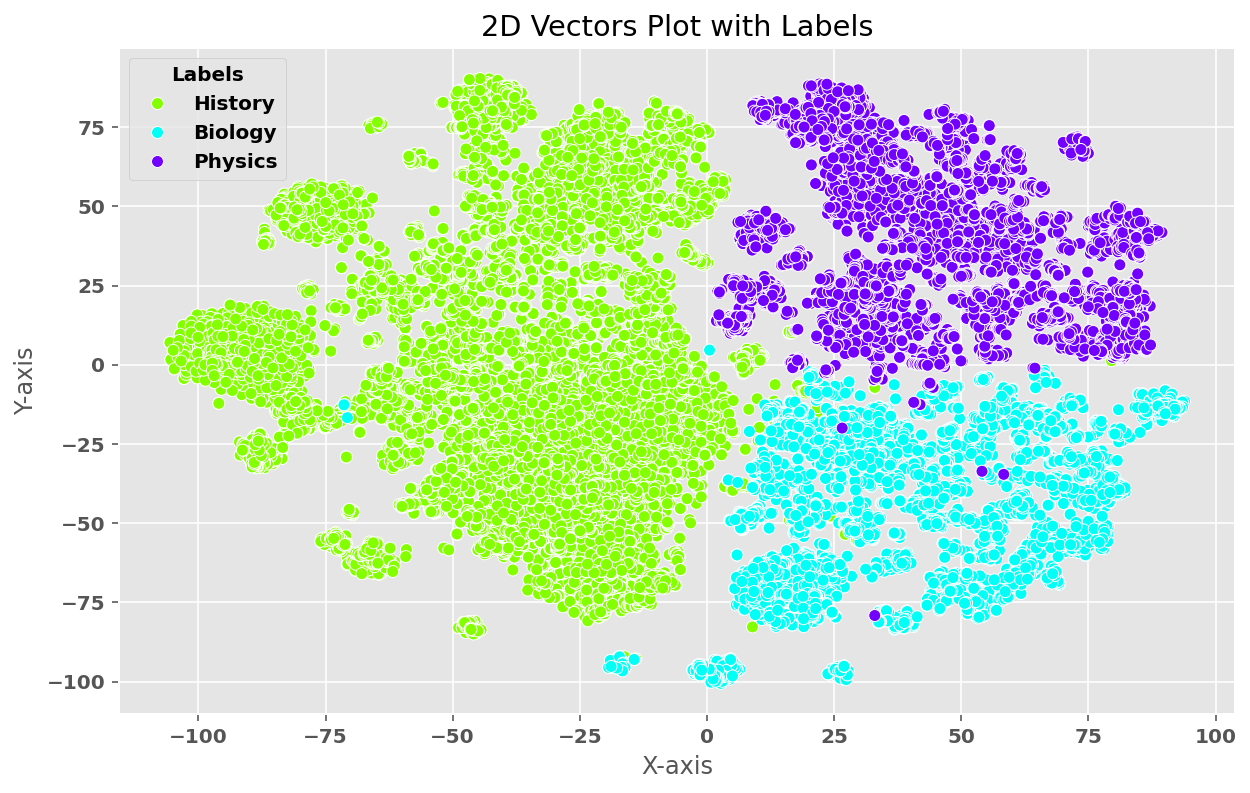

In [18]:
vectors = np.array(vectors)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=vectors[:, 0], y=vectors[:, 1], hue=true_labels, palette=sns.color_palette('hsv', len(set(true_labels))))


plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('2D Vectors Plot with Labels')
plt.legend(title='Labels')
plt.grid(True)
plt.show()

## **Clustering**

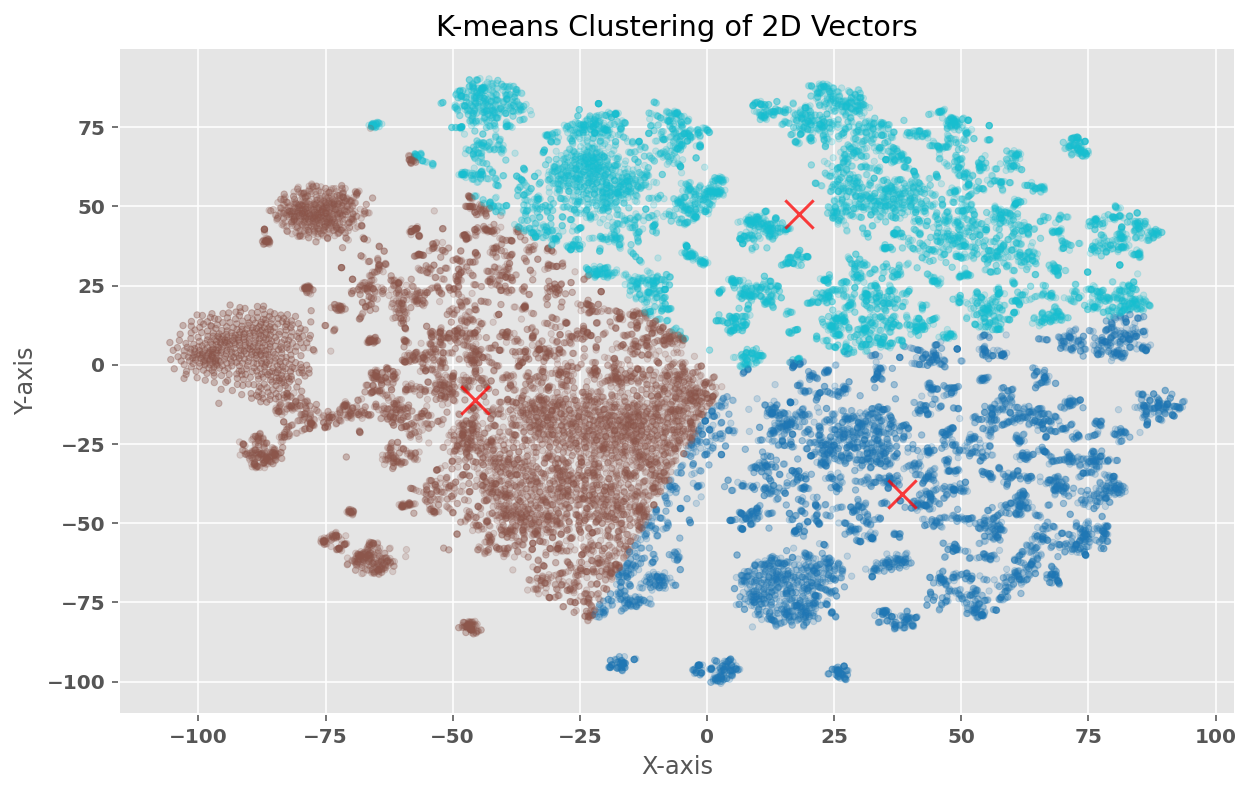

In [19]:
# Perform K-means clustering
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(vectors)
pred_labels = kmeans.labels_

# Plotting the clustered data
plt.figure(figsize=(10, 6))
plt.scatter(vectors[:, 0], vectors[:, 1], c=pred_labels, cmap='tab10', marker='o', alpha=0.2, s=10)

# Plot the cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('K-means Clustering of 2D Vectors')
plt.grid(True)
plt.show()

In [20]:
vector_labels = [(row["embedding"], row["label"]) for row in raw_dataset_embeddings]

vectors = [vector_label[0] for vector_label in vector_labels]
labels = [vector_label[1] for vector_label in vector_labels]

vectors = np.array(vectors, dtype=np.float32)

#print(vectors.shape, vectors.dtype)
print(f"Number of vectors is {vectors.shape}")

Number of vectors is (25600, 768)


In [21]:
# Perform K-means clustering
num_clusters = 3  
kmeans = KMeans(n_clusters=num_clusters, random_state=0)
kmeans.fit(vectors)
pred_labels = kmeans.labels_

In [22]:
reduced_vectors = np.array(reduced_vectors)

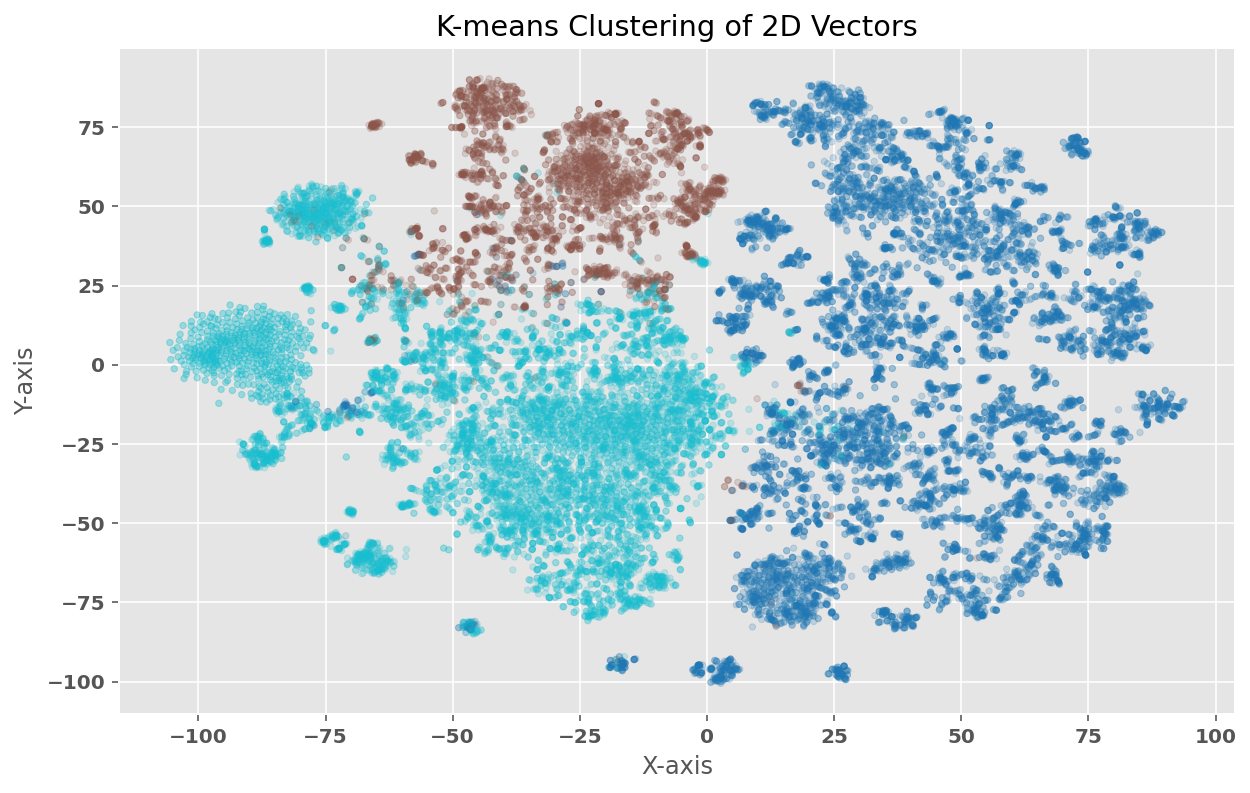

In [23]:

# Plotting the clustered data
plt.figure(figsize=(10, 6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=pred_labels, cmap='tab10', marker='o', alpha=0.2, s=10)

# Plot the cluster centers
#centers = kmeans.cluster_centers_
#plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='x')

plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('K-means Clustering of 2D Vectors')
plt.grid(True)
plt.show()